# KE5018 Time Series Forecasting

## Load libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load time series data

In [2]:
ts_df = pd.read_excel('data/ActualRatings_weeklyGRP.xls', sheet_name=1)

In [3]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
GRPRatingsDate    92 non-null object
GRP               92 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [4]:
ts_df.head()

,GRPRatingsDate,GRP
0,17-Jun-2007 (25),243.60
1,24-Jun-2007 (26),263.19
2,01-Jul-2007 (27),269.89
3,08-Jul-2007 (28),252.88
4,15-Jul-2007 (29),303.46


In [5]:
ts_df.tail()

,GRPRatingsDate,GRP
87,15-Feb-2009 (8),204.20
88,22-Feb-2009 (9),200.61
89,01-Mar-2009 (10),208.56
90,08-Mar-2009 (11),191.74
91,15-Mar-2009 (12),222.07


## Transform the Data for Analysis

In [6]:
# Create a date/time column for week.
ts_df['weekly_date'] = pd.date_range('17/6/2007', '15/3/2009', freq='W')

In [7]:
ts_df.head()

,GRPRatingsDate,GRP,weekly_date
0,17-Jun-2007 (25),243.60,2007-06-17
1,24-Jun-2007 (26),263.19,2007-06-24
2,01-Jul-2007 (27),269.89,2007-07-01
3,08-Jul-2007 (28),252.88,2007-07-08
4,15-Jul-2007 (29),303.46,2007-07-15


In [8]:
# Index the data frame by week. Keep the original index as a running number by week. 
ts_df.reset_index(inplace=True)
ts_df.set_index('weekly_date', inplace=True)

In [9]:
ts_df.head()

,index,GRPRatingsDate,GRP
weekly_date,,,
2007-06-17,0,17-Jun-2007 (25),243.60
2007-06-24,1,24-Jun-2007 (26),263.19
2007-07-01,2,01-Jul-2007 (27),269.89
2007-07-08,3,08-Jul-2007 (28),252.88
2007-07-15,4,15-Jul-2007 (29),303.46


In [10]:
ts_df.rename(columns={'index':'week'}, inplace=True)

In [11]:
ts_df.describe()

,week,GRP
count,92.00000,92.000000
mean,45.50000,240.829783
std,26.70206,38.680913
min,0.00000,170.740000
25%,22.75000,209.980000
50%,45.50000,231.490000
75%,68.25000,272.927500
max,91.00000,327.220000


## Show the Time Series Data

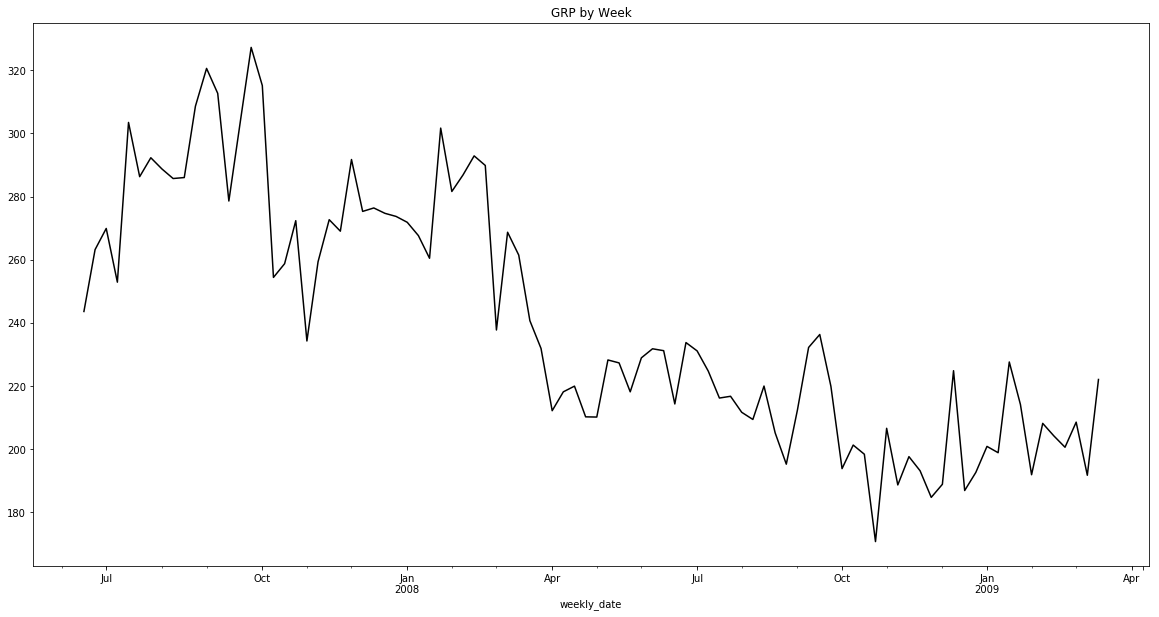

In [12]:
ts_df['GRP'].plot(figsize=(20, 10), title='GRP by Week', color='black')

As the plot for the time series data show a decreasing seasonal variation, we can try a Box-Cox transformation to convert the changing variation to a constant variation.

In [13]:
# Lambda was found from the boxcox function prior to this.
BOXCOX_LAMBDA = -0.5677106
ts_df['GRP_boxcox'] = boxcox(ts_df['GRP'], lmbda=BOXCOX_LAMBDA)
ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792


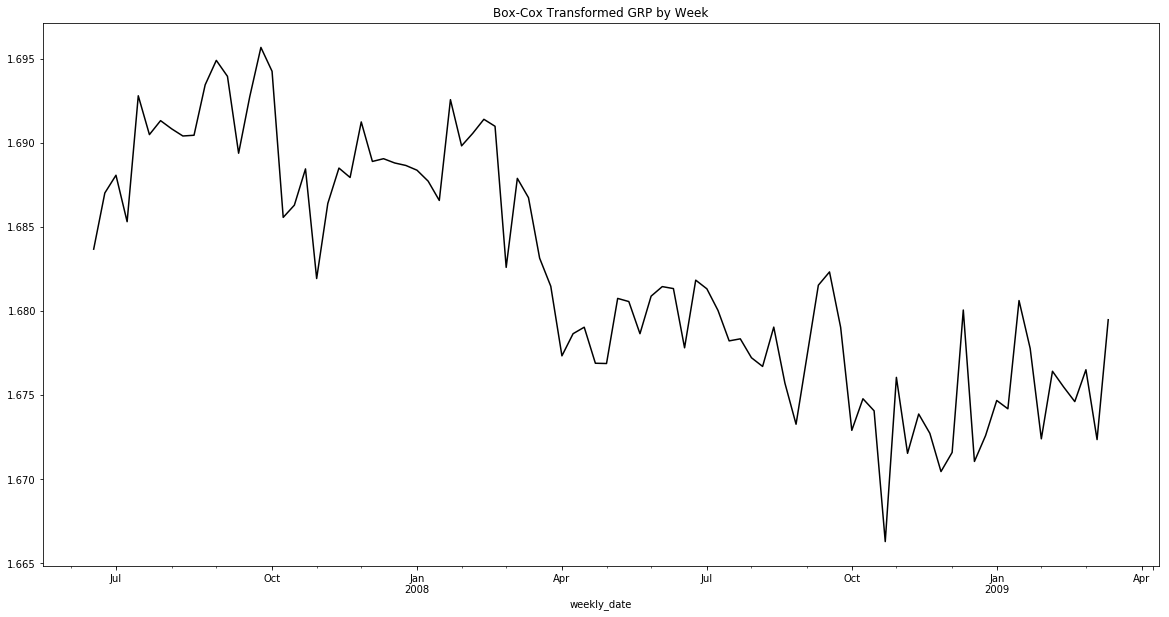

In [14]:
ts_df['GRP_boxcox'].plot(figsize=(20, 10), title='Box-Cox Transformed GRP by Week', color='black')

The possible seasonal variation is reduced after the Box-Cox transformation.

In [15]:
# Save the data frame to file.
ts_df.to_csv('data/transformedRatings.csv')

## Prepare the Train / Test Datasets

In [16]:
train_ts_df = ts_df.loc[:'26/10/2008']
test_ts_df = ts_df.loc['11/2008':]

In [17]:
train_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2007-06-17 to 2008-10-26
Data columns (total 4 columns):
week              72 non-null int64
GRPRatingsDate    72 non-null object
GRP               72 non-null float64
GRP_boxcox        72 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.8+ KB


In [18]:
test_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2008-11-02 to 2009-03-15
Data columns (total 4 columns):
week              20 non-null int64
GRPRatingsDate    20 non-null object
GRP               20 non-null float64
GRP_boxcox        20 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 800.0+ bytes


In [19]:
train_ts_df['GRP'].values

array([ 243.6 ,  263.19,  269.89,  252.88,  303.46,  286.29,  292.28,
        288.72,  285.7 ,  286.01,  308.59,  320.57,  312.67,  278.58,
        303.06,  327.22,  315.14,  254.39,  258.73,  272.35,  234.26,
        259.35,  272.67,  269.03,  291.72,  275.29,  276.38,  274.68,
        273.7 ,  271.84,  267.63,  260.45,  301.67,  281.6 ,  286.82,
        292.87,  289.84,  237.74,  268.69,  261.46,  240.68,  231.89,
        212.18,  218.16,  219.96,  210.24,  210.17,  228.25,  227.32,
        218.16,  228.92,  231.79,  231.19,  214.32,  233.76,  231.12,
        224.72,  216.19,  216.75,  211.68,  209.41,  219.99,  205.17,
        195.25,  212.45,  232.21,  236.31,  219.91,  193.84,  201.3 ,
        198.4 ,  170.74])

In [20]:
# Save train, test datasets to file.
train_ts_df.to_csv('data/transformedTrainRatings.csv')
test_ts_df.to_csv('data/transformedTestRatings.csv')

## Linear Regression Model

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP_boxcox'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
lin_reg.coef_

array([-0.00025072])

In [23]:
lin_reg.intercept_

1.6932900725993658

### Training Results

In [24]:
lin_reg_train_pred = inv_boxcox(lin_reg.predict(train_ts_df['week'].values.reshape(-1, 1)), BOXCOX_LAMBDA)
lin_reg_train_pred[:10]

array([ 307.37363512,  305.39241774,  303.43114734,  301.48955134,
        299.56736189,  297.66431573,  295.7801541 ,  293.91462266,
        292.06747139,  290.23845449])

In [25]:
lin_reg_train_mse = mean_squared_error(train_ts_df['GRP'].values, lin_reg_train_pred)
lin_reg_train_mse

499.83553871496628

In [26]:
lin_reg_train_rmse = np.sqrt(lin_reg_train_mse)
lin_reg_train_rmse

22.357002006417726

In [27]:
lin_reg_r2 = r2_score(train_ts_df['GRP'].values, lin_reg_train_pred)
lin_reg_r2

0.61634459075760795

In [28]:
lin_reg_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - lin_reg_train_pred) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
lin_reg_train_mape

6.6889611996426792

### Test Results

In [29]:
lin_reg_test_pred = inv_boxcox(lin_reg.predict(test_ts_df['week'].values.reshape(-1, 1)), BOXCOX_LAMBDA)
lin_reg_test_pred[:10]

array([ 203.21520658,  202.17849431,  201.15004947,  200.12978249,
        199.11760507,  198.11343008,  197.11717159,  196.12874483,
        195.14806618,  194.17505314])

In [30]:
lin_reg_test_mse = mean_squared_error(test_ts_df['GRP'].values, lin_reg_test_pred)
lin_reg_test_rmse = np.sqrt(lin_reg_test_mse)
lin_reg_test_mape = np.sum(np.abs(test_ts_df['GRP'].values - lin_reg_test_pred) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100
print('mse = %f\nrmse = %f\nmape = %f'% (lin_reg_test_mse, lin_reg_test_rmse, lin_reg_test_mape))

mse = 296.395114
rmse = 17.216129
mape = 6.610052


In [31]:
results_list = []
results_list.append([lin_reg_train_mse, lin_reg_train_rmse, lin_reg_train_mape, lin_reg_r2, lin_reg_test_mse, lin_reg_test_rmse, lin_reg_test_mape])
results_list

[[499.83553871496628,
  22.357002006417726,
  6.6889611996426792,
  0.61634459075760795,
  296.3951144909862,
  17.21612948635628,
  6.6100519603490779]]

### Plot the Predicted Results

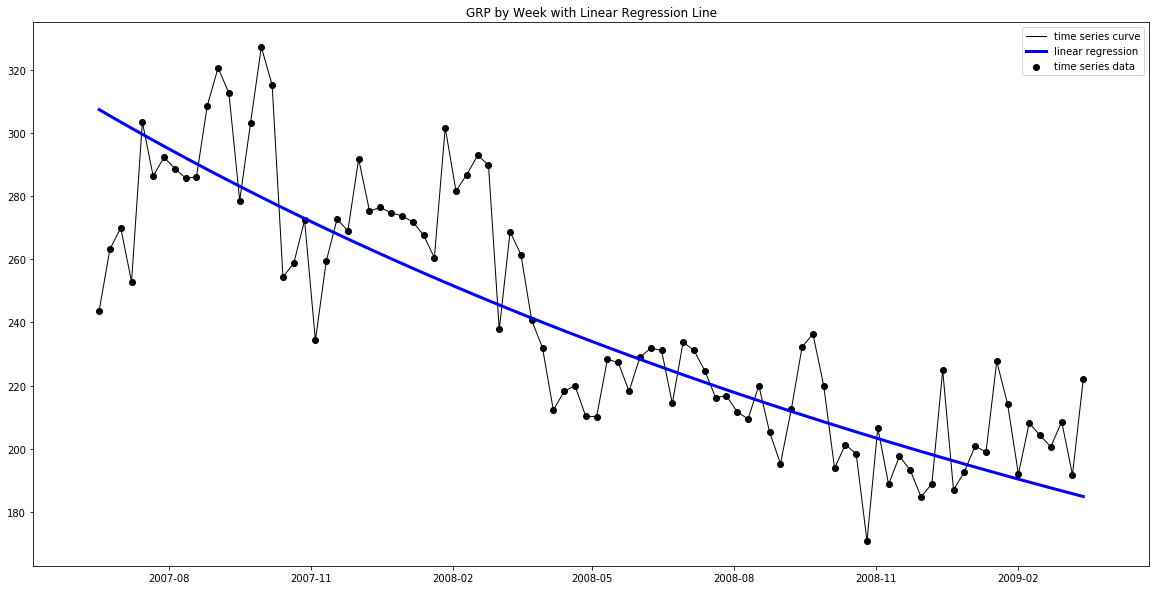

In [32]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Linear Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([lin_reg_train_pred, lin_reg_test_pred]), color='blue', linewidth=3, label='linear regression')
plt.legend()
plt.show()

### Analysis of Residuals

In [33]:
residuals = train_ts_df['GRP'].values - lin_reg_train_pred
residuals

array([-63.77363512, -42.20241774, -33.54114734, -48.60955134,
         3.89263811, -11.37431573,  -3.5001541 ,  -5.19462266,
        -6.36747139,  -4.22845449,  20.16266969,  33.93613872,
        27.81218621,  -4.51895813,  21.70293158,  47.58807749,
        37.21669806, -21.84099183, -15.82478083,  -0.54446104,
       -36.98982795, -10.27068037,   4.66317964,   2.62194681,
        26.89581275,  12.03496602,  14.67959215,  14.51987371,
        15.0659904 ,  14.71811907,  12.00643377,   6.31110583,
        49.00230391,  30.39019401,  37.05493959,  44.53670153,
        42.92563826,  -7.76809423,  24.57565763,  18.72704508,
        -0.68378294,  -8.11667977, -26.48150097, -19.16810426,
       -16.04634952, -24.45609875, -23.22721597,  -3.85956727,
        -3.51302071, -11.40744631,   0.607284  ,   4.72129639,
         5.35471517, -10.29233715,  10.36026015,   8.92262603,
         3.71487771,  -3.63286927,  -1.90050104,  -5.80790535,
        -6.92497159,   4.79840929,  -8.88765521, -17.68

In [34]:
poly_reg_res = Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression(fit_intercept=False))])
poly_reg_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
poly_reg_res_pred = poly_reg_res.predict(train_ts_df['week'].values.reshape(-1, 1))

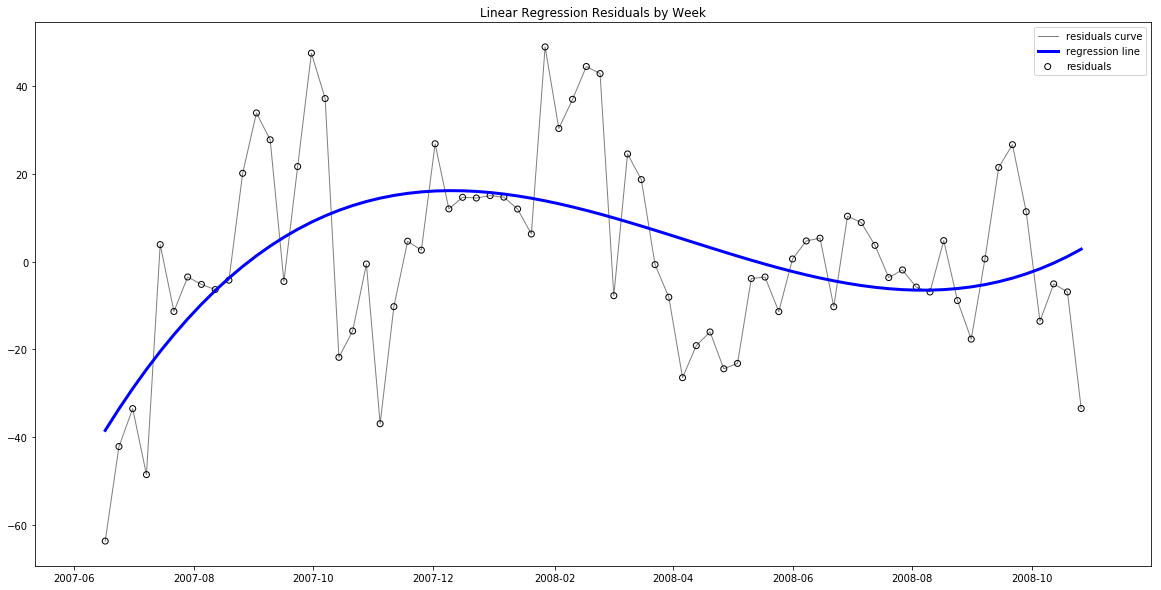

In [35]:
plt.figure(figsize=(20, 10))
plt.title('Linear Regression Residuals by Week')
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, poly_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

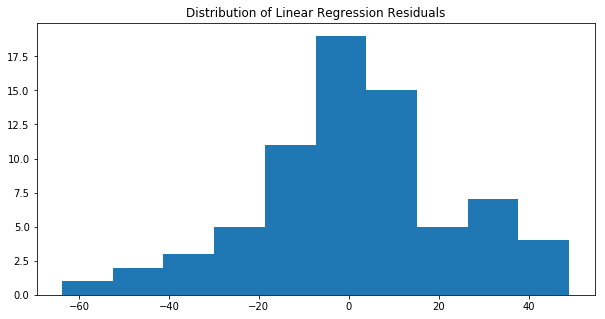

In [36]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of Linear Regression Residuals')
plt.hist(residuals)
plt.show()

In [37]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,24.750580,6.524916e-07
1,2,34.882851,2.662472e-08
2,3,43.249261,2.178644e-09
3,4,45.538383,3.072418e-09
4,5,45.758956,1.016838e-08
5,6,45.802282,3.241363e-08
6,7,46.270774,7.742889e-08
7,8,46.871233,1.622540e-07
8,9,48.999505,1.660171e-07
9,10,51.825091,1.229417e-07


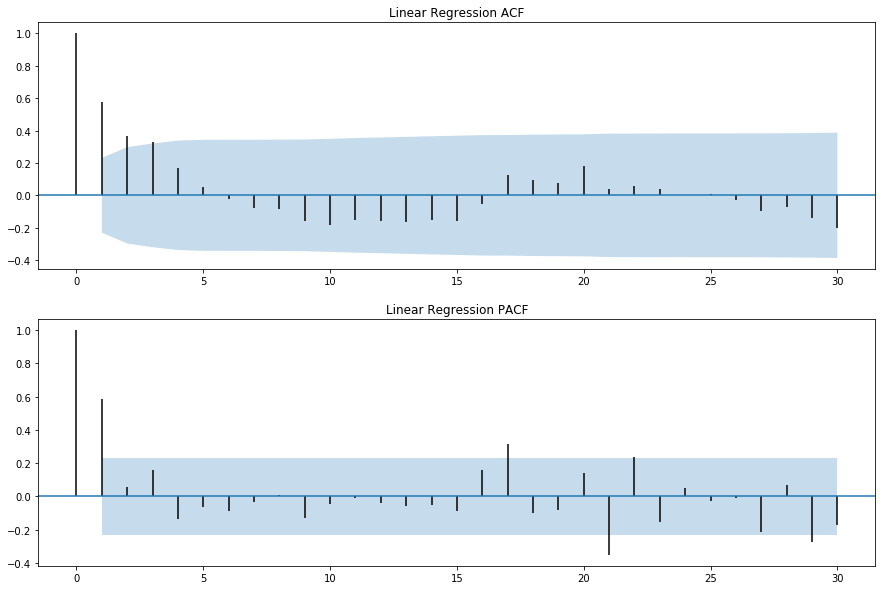

In [38]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=30, title='Linear Regression ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=30, title='Linear Regression PACF', marker=None)
plt.show()

The residuals are not white noise. The linear model is not a suitable functional form for the time series data.

## Polynomial Regression Model

In [39]:
poly_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression(fit_intercept=True))])
poly_reg.fit(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP_boxcox'])
poly_reg_train_pred = inv_boxcox(poly_reg.predict(train_ts_df['week'].values.reshape(-1, 1)), BOXCOX_LAMBDA)

In [40]:
poly_reg.named_steps['linear'].coef_

array([  0.00000000e+00,   4.54233397e-04,  -1.94692070e-05,
         1.48608767e-07])

In [41]:
poly_reg.named_steps['linear'].intercept_

1.6877248531596765

### Training Results

In [42]:
poly_reg_train_mse = mean_squared_error(train_ts_df['GRP'].values, poly_reg_train_pred)
poly_reg_train_rmse = np.sqrt(poly_reg_train_mse)
print('mse = %f\nrmse = %f' % (poly_reg_train_mse, poly_reg_train_rmse))

mse = 352.265721
rmse = 18.768743


In [43]:
poly_reg_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - poly_reg_train_pred) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
poly_reg_train_mape

5.7893677610090331

In [44]:
poly_reg_r2 = r2_score(train_ts_df['GRP'].values, poly_reg_train_pred)
poly_reg_r2

0.72961376518013121

### Test Results

In [45]:
poly_reg_test_pred = inv_boxcox(poly_reg.predict(test_ts_df['week'].values.reshape(-1, 1)), BOXCOX_LAMBDA)
poly_reg_test_mse = mean_squared_error(test_ts_df['GRP'].values, poly_reg_test_pred)
poly_reg_test_rmse = np.sqrt(poly_reg_test_mse)
print('mse = %f\nrmse = %f' % (poly_reg_test_mse, poly_reg_test_rmse))

mse = 192.449108
rmse = 13.872603


In [46]:
poly_reg_test_mape = np.sum(np.abs(test_ts_df['GRP'].values - poly_reg_test_pred) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100
poly_reg_test_mape

5.992912295971804

In [47]:
results_list.append([poly_reg_train_mse, poly_reg_train_rmse, poly_reg_train_mape, poly_reg_r2, poly_reg_test_mse, poly_reg_test_rmse, poly_reg_test_mape])
results_list

[[499.83553871496628,
  22.357002006417726,
  6.6889611996426792,
  0.61634459075760795,
  296.3951144909862,
  17.21612948635628,
  6.6100519603490779],
 [352.26572097388066,
  18.768743191111138,
  5.7893677610090331,
  0.72961376518013121,
  192.44910846542419,
  13.872602800679626,
  5.992912295971804]]

### Plot the Predicted Results

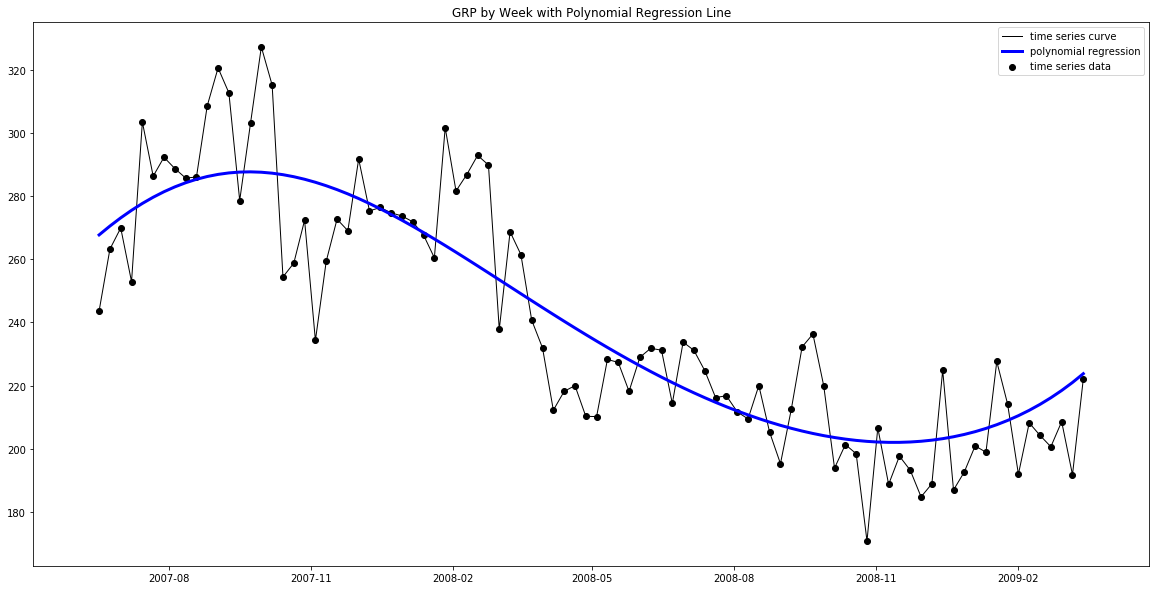

In [48]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Polynomial Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([poly_reg_train_pred, poly_reg_test_pred]), color='blue', linewidth=3, label='polynomial regression')
plt.legend()
plt.show()

The polynomial regression model generalises poorly to the test data. Higher degree polynomial models perform worse.

### Analysis of Residuals

In [49]:
residuals = train_ts_df['GRP'].values - poly_reg_train_pred
poly_reg_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=4)),
        ('linear', LinearRegression(fit_intercept=False))])
poly_reg_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
poly_reg_res_pred = poly_reg_res.predict(train_ts_df['week'].values.reshape(-1, 1))

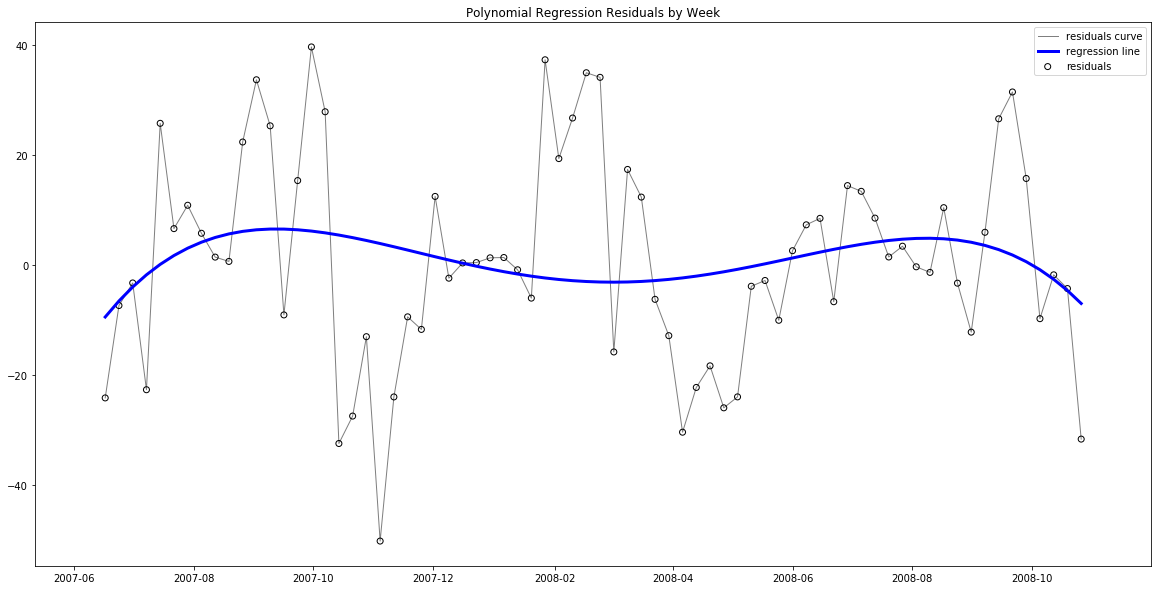

In [50]:
plt.figure(figsize=(20, 10))
plt.title('Polynomial Regression Residuals by Week')
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, poly_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

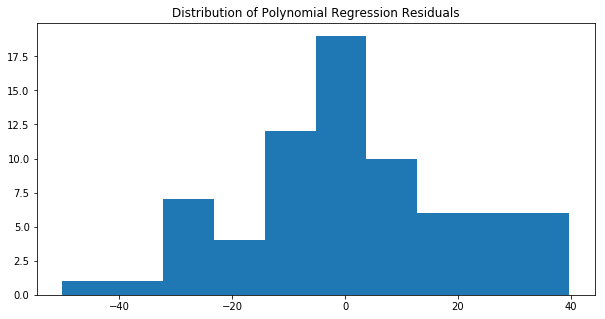

In [51]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of Polynomial Regression Residuals')
plt.hist(residuals)
plt.show()

In [52]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,17.136744,0.000035
1,2,21.348169,0.000023
2,3,25.542211,0.000012
3,4,26.210443,0.000029
4,5,26.655869,0.000067
5,6,28.561326,0.000074
6,7,32.081507,0.000039
7,8,35.130665,0.000025
8,9,40.842260,0.000005
9,10,46.499216,0.000001


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


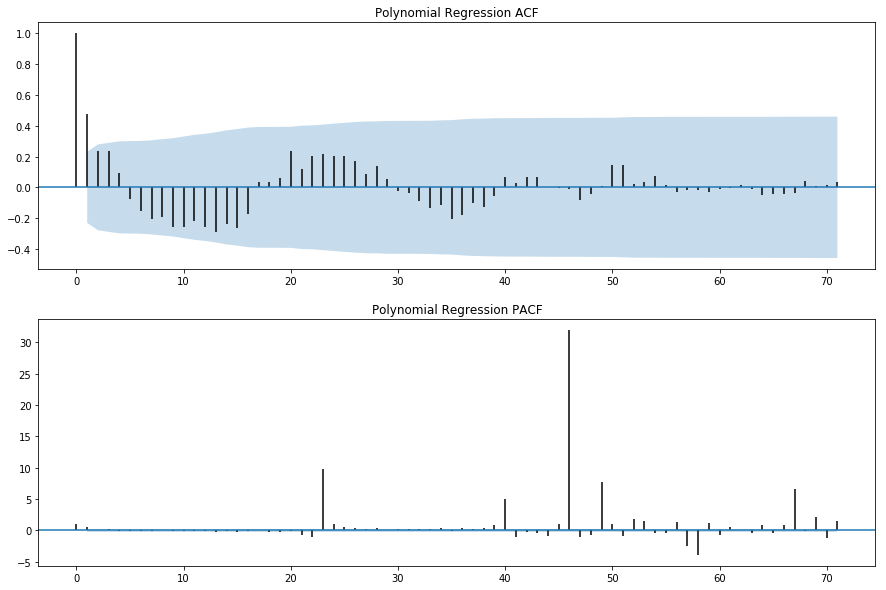

In [53]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, title='Polynomial Regression ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, title='Polynomial Regression PACF', marker=None)
plt.show()

The residuals exhibits autocorrelation at lag 1. There is variance not fully accounted for by the model.

## Dummy Variable Regression

### Create the Dummy Variables for Month

In [54]:
ts_df['month'] = ts_df.index.month

In [55]:
pd.get_dummies(ts_df['month']).head()

,1,2,3,4,5,6,7,8,9,10,11,12
weekly_date,,,,,,,,,,,,
2007-06-17,0,0,0,0,0,1,0,0,0,0,0,0
2007-06-24,0,0,0,0,0,1,0,0,0,0,0,0
2007-07-01,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-08,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-15,0,0,0,0,0,0,1,0,0,0,0,0


In [56]:
ts_dummy_df = pd.concat([pd.get_dummies(ts_df['month']), ts_df.drop(labels='month', axis=1)], axis=1)

In [57]:
ts_dummy_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,,,,,,,,,,,,,
2007-06-17,0,0,0,0,0,1,0,0,0,0,0,0,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,0,0,0,0,0,1,0,0,0,0,0,0,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,0,0,0,0,0,0,1,0,0,0,0,0,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,0,0,0,0,0,0,1,0,0,0,0,0,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,0,0,0,0,0,0,1,0,0,0,0,0,4,15-Jul-2007 (29),303.46,1.692792


In [58]:
# Split into training and test datasets.
train_ts_dummy_df = ts_dummy_df.loc['17/6/2007':'17/6/2008']
test_ts_dummy_df = ts_dummy_df.loc['18/6/2008':]

### Linear Regression Model with Dummy Variables

In [59]:
# Using GRP
dummy_var_reg = LinearRegression()
dummy_var_reg.fit(train_ts_dummy_df.iloc[:, :13].values, train_ts_dummy_df['GRP'])
dummy_var_reg_train_pred = dummy_var_reg.predict(train_ts_dummy_df.iloc[:, :13].values)

# Using GRP_boxcox
dummy_var_reg_trnsf = LinearRegression()
dummy_var_reg_trnsf.fit(train_ts_dummy_df.iloc[:, :13].values, train_ts_dummy_df['GRP_boxcox'])
dummy_var_reg_trnsf_train_pred = inv_boxcox(dummy_var_reg_trnsf.predict(train_ts_dummy_df.iloc[:, :13].values), BOXCOX_LAMBDA)

In [60]:
dummy_var_reg.coef_

array([ 11.98168709,  25.98433258, -11.88631625, -43.02346508,
       -35.5658196 , -23.55648949,   6.82728576,  19.94213693,
        37.9269881 ,   6.47933927,  -8.22801524,  13.11833593,  -0.40441137])

In [61]:
dummy_var_reg.intercept_

275.75035972124812

In [62]:
dummy_var_reg_trnsf.coef_

array([  2.25741975e-03,   4.43755162e-03,  -1.55580508e-03,
        -7.61147543e-03,  -6.08365218e-03,  -3.65774349e-03,
         1.08319803e-03,   3.10257882e-03,   5.48435888e-03,
         1.12624429e-03,  -1.02773896e-03,   2.44506374e-03,
        -7.40924491e-05])

In [63]:
dummy_var_reg_trnsf.intercept_

1.6888050179598169

### Training Results

In [64]:
# Using GRP
dummy_var_reg_train_mse = mean_squared_error(train_ts_dummy_df['GRP'].values, dummy_var_reg_train_pred)
dummy_var_reg_train_rmse = np.sqrt(dummy_var_reg_train_mse)
dummy_var_reg_train_mape = np.sum(np.abs(train_ts_dummy_df['GRP'].values - dummy_var_reg_train_pred) / train_ts_dummy_df['GRP'].values)\
                           / len(train_ts_dummy_df['GRP'].values) * 100

print('mse = %f\nrmse = %f\nmape = %f' % (dummy_var_reg_train_mse, dummy_var_reg_train_rmse, dummy_var_reg_train_mape))

mse = 178.852264
rmse = 13.373566
mape = 3.792109


In [65]:
dummy_var_reg_r2 = r2_score(train_ts_dummy_df['GRP'].values, dummy_var_reg_train_pred)
dummy_var_reg_r2

0.81013117337633256

In [66]:
# Using GRP_boxcox
dummy_var_reg_trnsf_train_mse = mean_squared_error(train_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_train_pred)
dummy_var_reg_trnsf_train_rmse = np.sqrt(dummy_var_reg_trnsf_train_mse)
dummy_var_reg_trnsf_train_mape = np.sum(np.abs(train_ts_dummy_df['GRP'].values - dummy_var_reg_trnsf_train_pred) / train_ts_dummy_df['GRP'].values) /\
                                 len(train_ts_dummy_df['GRP'].values) * 100

print('mse = %f\nrmse = %f\nmape = %f' % (dummy_var_reg_trnsf_train_mse, dummy_var_reg_trnsf_train_rmse, dummy_var_reg_trnsf_train_mape))

mse = 179.818969
rmse = 13.409660
mape = 3.769918


In [67]:
dummy_var_reg_trnsf_r2 = r2_score(train_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_train_pred)
dummy_var_reg_trnsf_r2

0.80910492335890627

### Test Results

In [68]:
# Using GRP
dummy_var_reg_test_pred = dummy_var_reg.predict(test_ts_dummy_df.iloc[:, :13].values)
dummy_var_reg_test_mse = mean_squared_error(test_ts_dummy_df['GRP'].values, dummy_var_reg_test_pred)
dummy_var_reg_test_rmse = np.sqrt(dummy_var_reg_test_mse)
dummy_var_reg_test_mape = np.sum(np.abs(test_ts_dummy_df['GRP'].values - dummy_var_reg_test_pred) / test_ts_dummy_df['GRP'].values)\
                          / len(test_ts_dummy_df['GRP'].values) * 100

print('mse = %f\nrmse = %f\nmape = %f' % (dummy_var_reg_test_mse, dummy_var_reg_test_rmse, dummy_var_reg_test_mape))

mse = 2819.982555
rmse = 53.103508
mape = 24.460839


In [69]:
# Using GRP_boxcox
dummy_var_reg_trnsf_test_pred = inv_boxcox(dummy_var_reg_trnsf.predict(test_ts_dummy_df.iloc[:, :13].values), BOXCOX_LAMBDA)
dummy_var_reg_trnsf_test_mse = mean_squared_error(test_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_test_pred)
dummy_var_reg_trnsf_test_rmse = np.sqrt(dummy_var_reg_trnsf_test_mse)
dummy_var_reg_trnsf_test_mape = np.sum(np.abs(test_ts_dummy_df['GRP'].values - dummy_var_reg_trnsf_test_pred) / test_ts_dummy_df['GRP'].values)\
                          / len(test_ts_dummy_df['GRP'].values) * 100
print('mse = %f\nrmse = %f\nmape = %f' % (dummy_var_reg_trnsf_test_mse, dummy_var_reg_trnsf_test_rmse, dummy_var_reg_trnsf_test_mape))

mse = 2405.384884
rmse = 49.044723
mape = 22.626541


In [70]:
results_list.append([dummy_var_reg_train_mse, dummy_var_reg_train_rmse, dummy_var_reg_train_mape, dummy_var_reg_r2,
                     dummy_var_reg_test_mse, dummy_var_reg_test_rmse, dummy_var_reg_test_mape])
results_list.append([dummy_var_reg_trnsf_train_mse, dummy_var_reg_trnsf_train_rmse, dummy_var_reg_trnsf_train_mape, dummy_var_reg_trnsf_r2,
                     dummy_var_reg_trnsf_test_mse, dummy_var_reg_trnsf_test_rmse, dummy_var_reg_trnsf_test_mape])
results_list

[[499.83553871496628,
  22.357002006417726,
  6.6889611996426792,
  0.61634459075760795,
  296.3951144909862,
  17.21612948635628,
  6.6100519603490779],
 [352.26572097388066,
  18.768743191111138,
  5.7893677610090331,
  0.72961376518013121,
  192.44910846542419,
  13.872602800679626,
  5.992912295971804],
 [178.85226448683554,
  13.373565885239266,
  3.7921086100608279,
  0.81013117337633256,
  2819.9825549438742,
  53.103507934446988,
  24.460838658819029],
 [179.81896946316181,
  13.409659558063426,
  3.7699184932382126,
  0.80910492335890627,
  2405.3848844684553,
  49.044723309123228,
  22.626540599485935]]

### Plot the Predicted Results

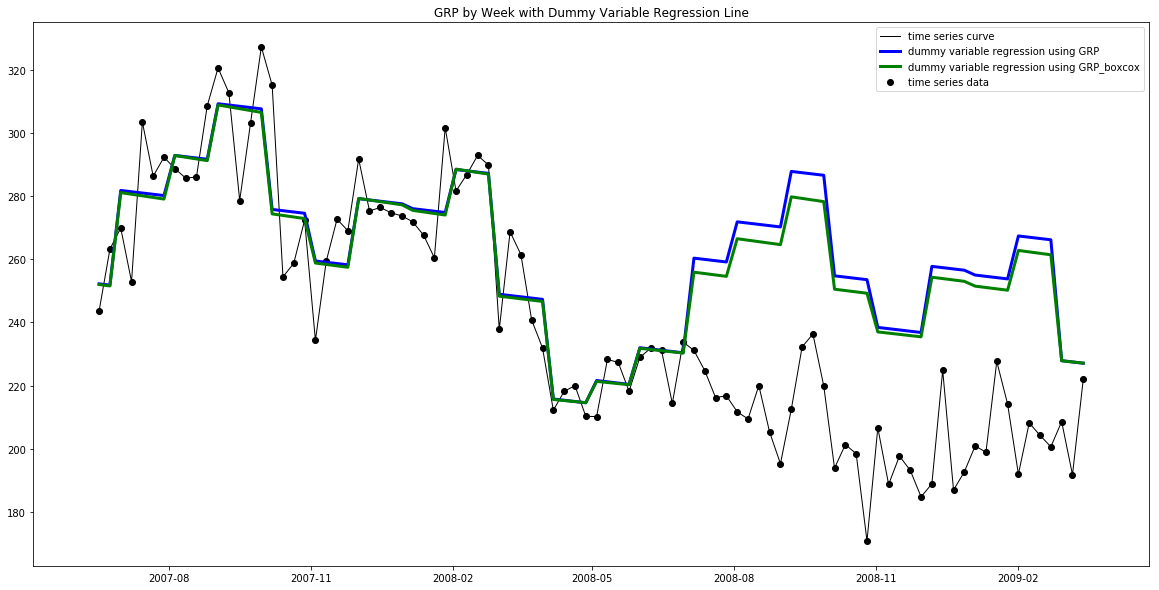

In [71]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Dummy Variable Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([dummy_var_reg_train_pred, dummy_var_reg_test_pred]), color='blue',
         linewidth=3, label='dummy variable regression using GRP')
plt.plot(ts_df.index.values, np.concatenate([dummy_var_reg_trnsf_train_pred, dummy_var_reg_trnsf_test_pred]), color='green',
         linewidth=3, label='dummy variable regression using GRP_boxcox')
plt.legend()
plt.show()

The dummy variable regression model generalises poorly to the test data. it fails to model the seasonality pattern, even using the Box-Cox transformation.

In [72]:
residuals = train_ts_dummy_df['GRP'].values - dummy_var_reg_trnsf_train_pred
dummy_var_reg_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=4)),
        ('linear', LinearRegression(fit_intercept=False))])
dummy_var_reg_res.fit(train_ts_dummy_df['week'].values.reshape(-1, 1), residuals)
dummy_var_reg_res_pred = dummy_var_reg_res.predict(train_ts_dummy_df['week'].values.reshape(-1, 1))

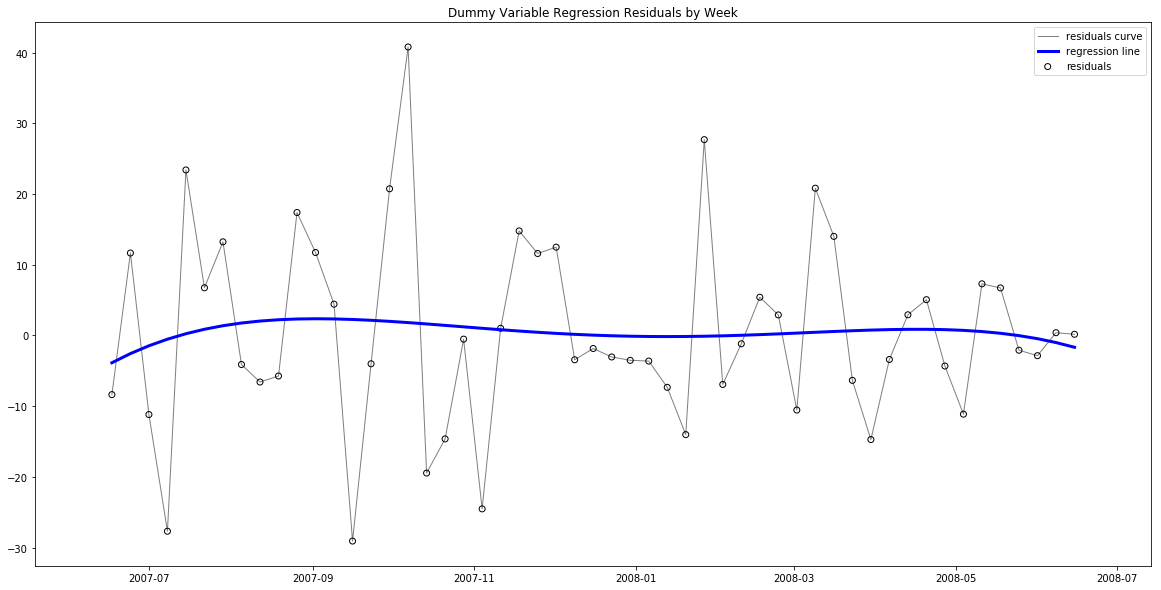

In [73]:
plt.figure(figsize=(20, 10))
plt.title('Dummy Variable Regression Residuals by Week')
plt.scatter(train_ts_dummy_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_dummy_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_dummy_df.index.values, dummy_var_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

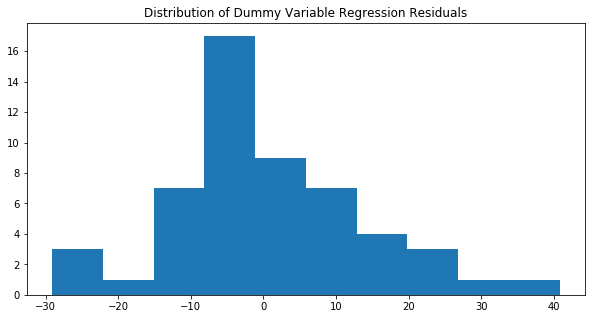

In [74]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of Dummy Variable Regression Residuals')
plt.hist(residuals)
plt.show()

In [75]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,0.001116,0.973345
1,2,7.169435,0.027744
2,3,10.289736,0.016257
3,4,10.365983,0.034694
4,5,10.591154,0.060117
5,6,12.554411,0.050684
6,7,12.890715,0.074816
7,8,13.379054,0.099456
8,9,13.959104,0.123787
9,10,15.053429,0.130126


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


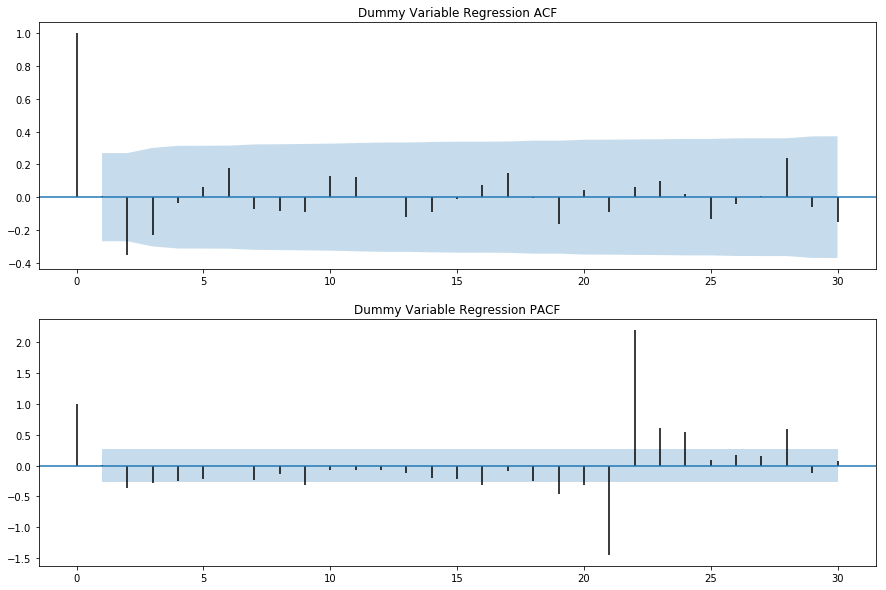

In [76]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, title='Dummy Variable Regression ACF', lags=30, marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, title='Dummy Variable Regression PACF', lags=30, marker=None)
plt.show()

The linear regression model using time and dummy variables for seasonality generalises poorly and the residuals exhibits some autocorrelation at lag 2 and maybe more. 

## 20 Week Seasonality Dummy Variable Model

In [77]:
ts_df['season'] = ts_df['week']%20
ts_df[18:22]

,week,GRPRatingsDate,GRP,GRP_boxcox,month,season
weekly_date,,,,,,
2007-10-21,18,21-Oct-2007 (43),258.73,1.686286,10,18
2007-10-28,19,28-Oct-2007 (44),272.35,1.688444,10,19
2007-11-04,20,04-Nov-2007 (45),234.26,1.681924,11,0
2007-11-11,21,11-Nov-2007 (46),259.35,1.686388,11,1


In [78]:
pd.get_dummies(ts_df['season']).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
weekly_date,,,,,,,,,,,,,,,,,,,,
2007-06-17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-06-24,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-07-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-07-08,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-07-15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
ts_season_df = pd.concat([pd.get_dummies(ts_df['season']), ts_df.drop(labels='season', axis=1)], axis=1)
ts_season_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,week,GRPRatingsDate,GRP,GRP_boxcox,month
weekly_date,,,,,,,,,,,,,,,,,,,,,
2007-06-17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17-Jun-2007 (25),243.60,1.683670,6
2007-06-24,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,24-Jun-2007 (26),263.19,1.687012,6
2007-07-01,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,2,01-Jul-2007 (27),269.89,1.688067,7
2007-07-08,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,3,08-Jul-2007 (28),252.88,1.685303,7
2007-07-15,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,4,15-Jul-2007 (29),303.46,1.692792,7


In [80]:
# Split into training and test datasets.
train_ts_season_df = ts_season_df.loc['17/6/2007':'17/6/2008']
test_ts_season_df = ts_season_df.loc['18/6/2008':]

In [81]:
# Using GRP
season20_reg = LinearRegression()
season20_reg.fit(train_ts_season_df.iloc[:, :21].values, train_ts_season_df['GRP'])
season20_reg_train_pred = season20_reg.predict(train_ts_season_df.iloc[:, :21].values)

# Using ln GRP
season20_reg_trnsf = LinearRegression()
season20_reg_trnsf.fit(train_ts_season_df.iloc[:, :21].values, train_ts_season_df['GRP_boxcox'])
season20_reg_trnsf_train_pred = inv_boxcox(season20_reg_trnsf.predict(train_ts_season_df.iloc[:, :21].values), BOXCOX_LAMBDA)

In [82]:
season20_reg.coef_

array([-36.53516243, -23.13087147, -21.58658051, -25.03562288,
         1.42866808, -11.57037429,  -7.79275   ,  -2.07845904,
        -2.28083475,  -4.40987712,   6.74108051,  10.7387048 ,
        23.0863291 ,   8.36437712,  24.65533475,  41.20129237,
        35.08725   , -19.89679237,  -0.81083475,   3.82512288,  -1.44095763])

In [83]:
season20_reg.intercept_

304.86764830508474

In [84]:
season20_reg_trnsf.coef_

array([ -5.77478110e-03,  -3.48962550e-03,  -3.57525941e-03,
        -4.00314520e-03,  -3.67502999e-05,  -2.06315648e-03,
        -1.49735119e-03,  -2.14290712e-04,  -2.26473787e-04,
        -7.02736983e-04,   1.06460939e-03,   1.59689041e-03,
         3.47928979e-03,   1.63217391e-03,   3.92705767e-03,
         6.04919920e-03,   5.37213412e-03,  -2.92773757e-03,
         3.22355640e-04,   1.06759810e-03,  -2.40429338e-04])

In [85]:
season20_reg_trnsf.intercept_

1.6934928309073003

### Train Results

In [86]:
# Using GRP
season20_reg_train_mse = mean_squared_error(train_ts_season_df['GRP'].values, season20_reg_train_pred)
season20_reg_train_rmse = np.sqrt(season20_reg_train_mse)
season20_reg_train_mape = np.sum(np.abs(train_ts_season_df['GRP'].values - season20_reg_train_pred) / train_ts_season_df['GRP'].values)\
                          / len(train_ts_season_df['GRP'].values) * 100
season20_reg_r2 = r2_score(train_ts_season_df['GRP'].values, season20_reg_train_pred)

print('mse = %f\nrmse = %f\nmape = %f\nr2      = %f' % (season20_reg_train_mse, season20_reg_train_rmse, season20_reg_train_mape, season20_reg_r2))

mse = 189.038690
rmse = 13.749134
mape = 4.454398
r2      = 0.799317


In [87]:
# Using GRP_boxcox
season20_reg_trnsf_train_mse = mean_squared_error(train_ts_season_df['GRP'].values, season20_reg_trnsf_train_pred)
season20_reg_trnsf_train_rmse = np.sqrt(season20_reg_trnsf_train_mse)
season20_reg_trnsf_train_mape = np.sum(np.abs(train_ts_season_df['GRP'].values - season20_reg_trnsf_train_pred) / train_ts_season_df['GRP'].values)\
                                / len(train_ts_season_df['GRP'].values) * 100
season20_reg_trnsf_r2 = r2_score(train_ts_season_df['GRP'].values, season20_reg_trnsf_train_pred)
print('mse = %f\nrmse = %f\nmape = %f\nr2       = %f' % (season20_reg_trnsf_train_mse, season20_reg_trnsf_train_rmse,
                                                         season20_reg_trnsf_train_mape, season20_reg_trnsf_r2))

mse = 197.129351
rmse = 14.040276
mape = 4.572934
r2       = 0.790728


### Test Results

In [88]:
# Using GRP
season20_reg_test_pred = season20_reg.predict(test_ts_season_df.iloc[:, :21].values)
season20_reg_test_mse = mean_squared_error(test_ts_season_df['GRP'].values, season20_reg_test_pred)
season20_reg_test_rmse = np.sqrt(season20_reg_test_mse)
season20_reg_test_mape = np.sum(np.abs(test_ts_season_df['GRP'].values - season20_reg_test_pred) / test_ts_season_df['GRP'].values)\
                          / len(test_ts_season_df['GRP'].values) * 100
print('mse = %f\nrmse = %f\nmape = %f' % (season20_reg_test_mse, season20_reg_test_rmse, season20_reg_test_mape))

mse = 814.333892
rmse = 28.536536
mape = 11.955567


In [89]:
# Using ln GRP
season20_reg_trnsf_test_pred = inv_boxcox(season20_reg_trnsf.predict(test_ts_season_df.iloc[:, :21].values), BOXCOX_LAMBDA)
season20_reg_trnsf_test_mse = mean_squared_error(test_ts_season_df['GRP'].values, season20_reg_trnsf_test_pred)
season20_reg_trnsf_test_rmse = np.sqrt(season20_reg_trnsf_test_mse)
season20_reg_trnsf_test_mape = np.sum(np.abs(test_ts_season_df['GRP'].values - season20_reg_trnsf_test_pred) / test_ts_season_df['GRP'].values)\
                          / len(test_ts_season_df['GRP'].values) * 100
print('mse = %f\nrmse = %f\nrmse = %f' % (season20_reg_trnsf_test_mse, season20_reg_trnsf_test_rmse, season20_reg_trnsf_test_mape))

mse = 460.577901
rmse = 21.461079
rmse = 8.786936


In [90]:
results_list.append([season20_reg_train_mse, season20_reg_train_rmse, season20_reg_train_mape, season20_reg_r2,
                     season20_reg_test_mse, season20_reg_test_rmse, season20_reg_test_mape])
results_list.append([season20_reg_trnsf_train_mse, season20_reg_trnsf_train_rmse, season20_reg_trnsf_train_mape, season20_reg_trnsf_r2,
                     season20_reg_trnsf_test_mse, season20_reg_trnsf_test_rmse, season20_reg_trnsf_test_mape])
results_list

[[499.83553871496628,
  22.357002006417726,
  6.6889611996426792,
  0.61634459075760795,
  296.3951144909862,
  17.21612948635628,
  6.6100519603490779],
 [352.26572097388066,
  18.768743191111138,
  5.7893677610090331,
  0.72961376518013121,
  192.44910846542419,
  13.872602800679626,
  5.992912295971804],
 [178.85226448683554,
  13.373565885239266,
  3.7921086100608279,
  0.81013117337633256,
  2819.9825549438742,
  53.103507934446988,
  24.460838658819029],
 [179.81896946316181,
  13.409659558063426,
  3.7699184932382126,
  0.80910492335890627,
  2405.3848844684553,
  49.044723309123228,
  22.626540599485935],
 [189.0386904807591,
  13.749134172040039,
  4.4543980644759538,
  0.79931730553683722,
  814.33389202074329,
  28.536536090085342,
  11.955567175570996],
 [197.12935123621418,
  14.040276038462142,
  4.5729340840807167,
  0.7907282934342732,
  460.57790137433489,
  21.461078756072233,
  8.7869360662880904]]

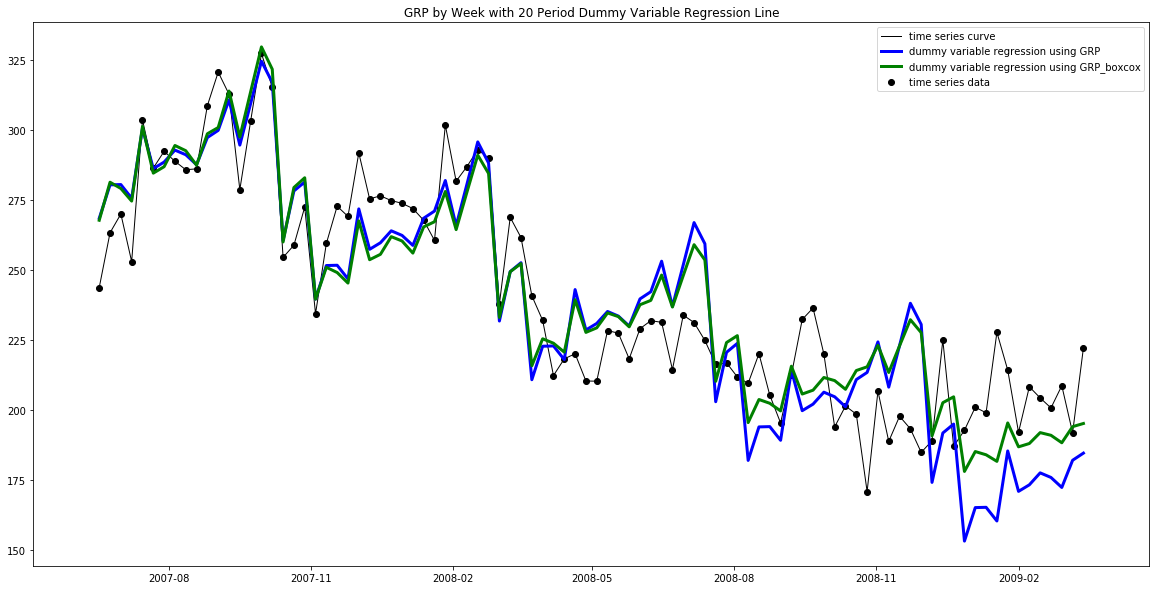

In [91]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with 20 Period Dummy Variable Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([season20_reg_train_pred, season20_reg_test_pred]), color='blue',
         linewidth=3, label='dummy variable regression using GRP')
plt.plot(ts_df.index.values, np.concatenate([season20_reg_trnsf_train_pred, season20_reg_trnsf_test_pred]), color='green',
         linewidth=3, label='dummy variable regression using GRP_boxcox')
plt.legend()
plt.show()

## Conclusion

In [92]:
results_df = pd.DataFrame(results_list, index=['Linear Regression', 'Polynomial Regression', 'Dummy Variable Regression', 'Dummy Variable Regression with Box_Cox',
                                               '20 Period Dummy Variable Regression', '20 Period Dummy Variable Regression with Box_Cox'],
                          columns=['train mse', 'train rmse', 'train mape', 'train r2', 'test mse', 'test rmse', 'test_mape'])
results_df

,train mse,train rmse,train mape,train r2,test mse,test rmse,test_mape
Linear Regression,499.835539,22.357002,6.688961,0.616345,296.395114,17.216129,6.610052
Polynomial Regression,352.265721,18.768743,5.789368,0.729614,192.449108,13.872603,5.992912
Dummy Variable Regression,178.852264,13.373566,3.792109,0.810131,2819.982555,53.103508,24.460839
Dummy Variable Regression with Box_Cox,179.818969,13.409660,3.769918,0.809105,2405.384884,49.044723,22.626541
20 Period Dummy Variable Regression,189.038690,13.749134,4.454398,0.799317,814.333892,28.536536,11.955567
20 Period Dummy Variable Regression with Box_Cox,197.129351,14.040276,4.572934,0.790728,460.577901,21.461079,8.786936


In [93]:
season20_reg.coef_

array([-36.53516243, -23.13087147, -21.58658051, -25.03562288,
         1.42866808, -11.57037429,  -7.79275   ,  -2.07845904,
        -2.28083475,  -4.40987712,   6.74108051,  10.7387048 ,
        23.0863291 ,   8.36437712,  24.65533475,  41.20129237,
        35.08725   , -19.89679237,  -0.81083475,   3.82512288,  -1.44095763])

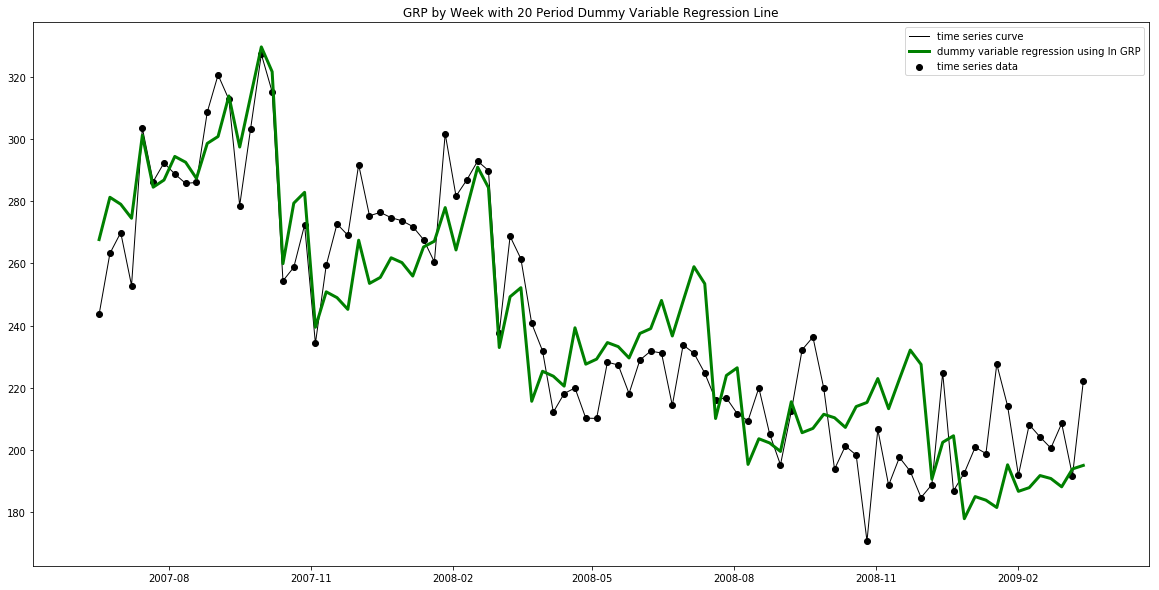

In [94]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with 20 Period Dummy Variable Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([season20_reg_trnsf_train_pred, season20_reg_trnsf_test_pred]), color='green',
         linewidth=3, label='dummy variable regression using ln GRP')
plt.legend()
plt.show()

### Analysis of Residuals

In [95]:
residuals = train_ts_season_df['GRP'].values - season20_reg_trnsf_train_pred
season20_reg_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=4)),
        ('linear', LinearRegression(fit_intercept=False))])
season20_reg_res.fit(train_ts_season_df['week'].values.reshape(-1, 1), residuals)
season20_reg_res_pred = season20_reg_res.predict(train_ts_season_df['week'].values.reshape(-1, 1))

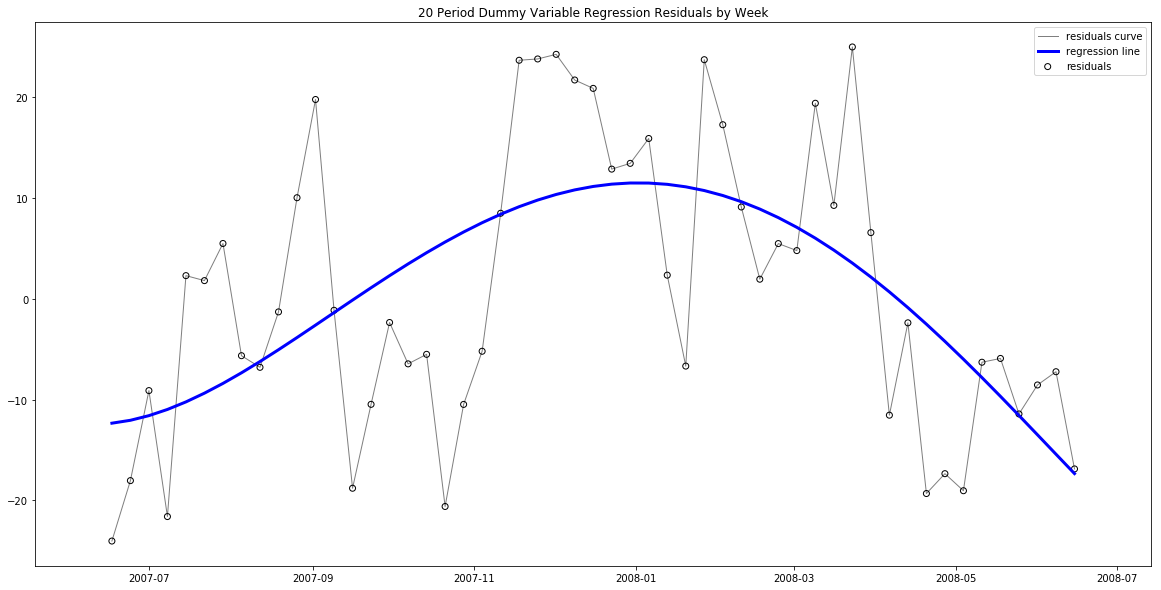

In [96]:
plt.figure(figsize=(20, 10))
plt.title('20 Period Dummy Variable Regression Residuals by Week')
plt.scatter(train_ts_season_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_season_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_season_df.index.values, season20_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

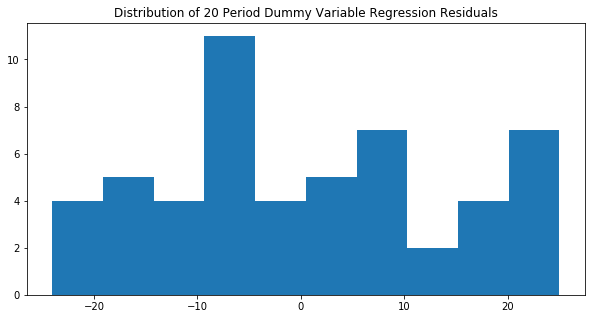

In [97]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of 20 Period Dummy Variable Regression Residuals')
plt.hist(residuals)
plt.show()

In [98]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,24.120307,9.050088e-07
1,2,35.018070,2.488414e-08
2,3,40.167830,9.817031e-09
3,4,42.346648,1.413751e-08
4,5,44.146147,2.163265e-08
5,6,44.939975,4.810519e-08
6,7,44.991286,1.372940e-07
7,8,45.302092,3.225253e-07
8,9,46.526392,4.807804e-07
9,10,46.813560,1.020928e-06


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


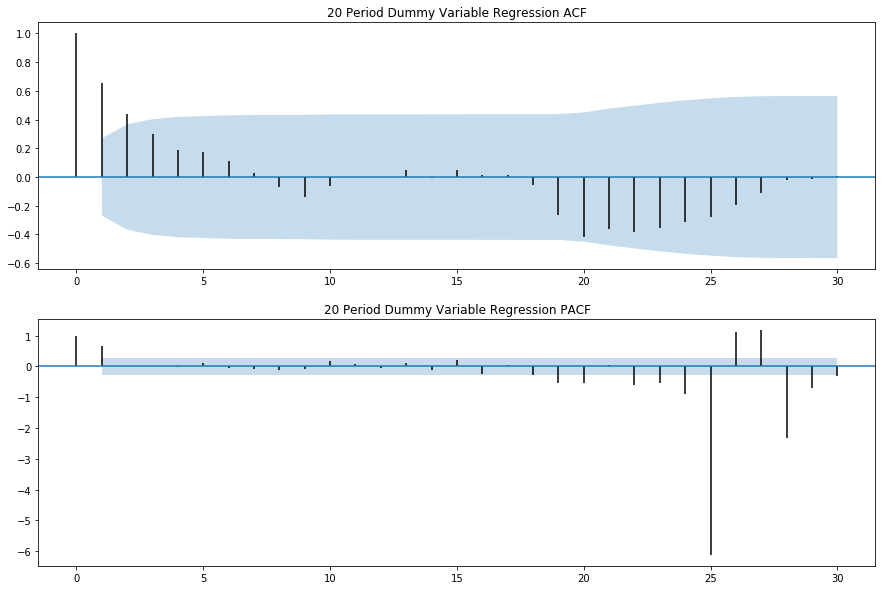

In [99]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=30, title='20 Period Dummy Variable Regression ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=30, title='20 Period Dummy Variable Regression PACF', marker=None)
plt.show()